In [1]:
import numpy as np
import torch 

from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# repository imports
from utils import DataManager, dataset_sizes, collect_training_data, compute_statistics
from probes import learn_truth_directions

In [2]:
# hyperparameters
model_family = 'Llama3' # options are 'Llama3', 'Llama2', 'Gemma', 'Gemma2' or 'Mistral'
model_size = '8B'
model_type = 'chat' # options are 'chat' or 'base'
layer = 12 # layer from which to extract activations

# define datasets used for training
# the ordering [affirmative_dataset1, negated_dataset1, affirmative_dataset2, negated_dataset2, ...] is required by some functions
train_sets = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans", "inventors", "neg_inventors", "animal_class",
                  "neg_animal_class", "element_symb", "neg_element_symb", "facts", "neg_facts"]
# get size of each training dataset to include an equal number of statements from each topic in training data
train_set_sizes = dataset_sizes(train_sets) 

### Separation between true and false statements across layers

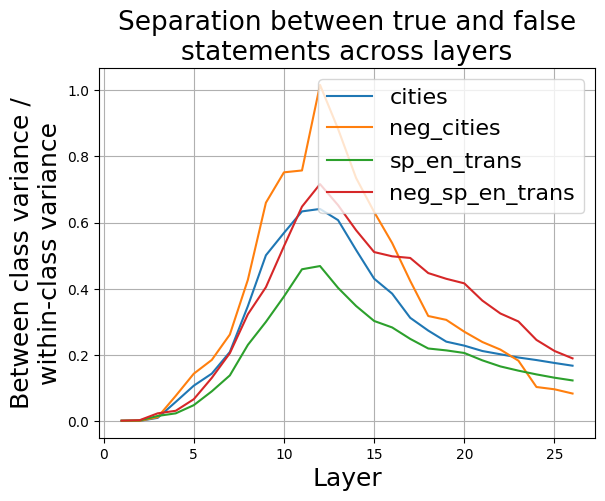

In [3]:
# find the layer with the largest separation between true and false statements
# you need to have stored the activations in layers 1-27 for all four datasets to run this cell
layers = np.arange(1, 27, 1)
datasets_separation = ['cities', 'neg_cities', 'sp_en_trans', 'neg_sp_en_trans']
for dataset in datasets_separation:
    between_class_variances = []
    within_class_variances = []
    for layer_nr in layers:
        dm = DataManager() 
        dm.add_dataset(dataset, model_family, model_size, model_type,
                        layer_nr, split=None, center=False, device='cpu')
        acts, labels = dm.data[dataset]
        # Calculate means for each class
        false_stmnt_ids = labels == 0
        true_stmnt_ids = labels == 1

        false_acts = acts[false_stmnt_ids]
        true_acts = acts[true_stmnt_ids]

        mean_false = false_acts.mean(dim=0)
        mean_true = true_acts.mean(dim=0)

        # Calculate within-class variance
        within_class_variance_false = false_acts.var(dim=0).mean()
        within_class_variance_true = true_acts.var(dim=0).mean()
        within_class_variances.append((within_class_variance_false + within_class_variance_true).item() / 2)

        # Calculate between-class variance
        overall_mean = acts.mean(dim=0)
        between_class_variances.append(((mean_false - overall_mean).pow(2) 
                                        + (mean_true - overall_mean).pow(2)).mean().item() / 2)

    plt.plot(layers, np.array(between_class_variances) / np.array(within_class_variances), label=dataset)
plt.legend(fontsize=16)
plt.ylabel('Between class variance /\nwithin-class variance', fontsize=18)
plt.xlabel('Layer', fontsize=18)
plt.title('Separation between true and false\nstatements across layers', fontsize=19)
plt.grid(True)

### Supervised learning of the truth directions and classification accuracies

In [4]:
nr_runs = 10
results = {'t_g': defaultdict(list), 't_p': defaultdict(list), 'd_{LR}': defaultdict(list)}

for _ in range(nr_runs):
    for i in range(0, len(train_sets), 2):
        # leave one dataset out (affirmative + negated)
        cv_train_sets = [set for j, set in enumerate(train_sets) if j not in (i, i+1)]
        
        # Collect training data
        acts_centered, _, labels, polarities = collect_training_data(cv_train_sets, train_set_sizes, model_family,
                                                          model_size, model_type, layer)
        
        # Fit model
        t_g, t_p = learn_truth_directions(acts_centered, labels, polarities)

        # fit LR for comparison
        LR = LogisticRegression(penalty=None, fit_intercept=False)
        LR.fit(acts_centered.numpy(), labels.numpy())
        d_lr = torch.from_numpy(LR.coef_[0]).float()
                
        # Evaluate on held-out sets, assuming affirmative and negated dataset on the same topic are at index i and i+1
        for j in range(2):
            dataset = train_sets[i+j]
            dm = DataManager()
            dm.add_dataset(dataset, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
            acts, labels = dm.get(dataset)

            auroc = roc_auc_score(labels.numpy(), (acts @ t_g).numpy())
            results['t_g'][dataset].append(auroc)
            auroc = roc_auc_score(labels.numpy(), (acts @ t_p).numpy())
            results['t_p'][dataset].append(auroc)
            auroc = roc_auc_score(labels.numpy(), (acts @ d_lr).numpy())
            results['d_{LR}'][dataset].append(auroc)

stat_results = compute_statistics(results)

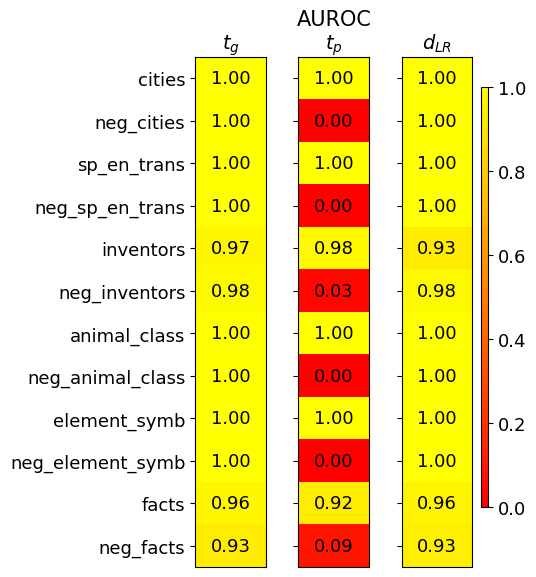

In [5]:
# Create a custom colormap from red to yellow
cmap = LinearSegmentedColormap.from_list('red_yellow', [(1, 0, 0), (1, 1, 0)], N=100)

# Create three subplots side-by-side
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(3.5, 6), ncols=3)

for ax, key in zip((ax1, ax2, ax3), ('t_g', 't_p', 'd_{LR}')):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in train_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_aspect('auto')
    ax.set_aspect(0.6)
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(train_sets)))
    ax.set_xticks([])
    ax.set_title(f"${key}$", fontsize=14)

ax1.set_yticklabels(train_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])

# Adjust the layout to make room for the colorbar
plt.subplots_adjust(top=0.9, bottom=0.05, left=0.1, right=0.9, wspace=0.4)

# Add colorbar with a specified position
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=13)

fig.suptitle("AUROC", fontsize=15)
plt.show()

### Activation vectors projected onto 2d truth subspace

In [6]:
# Compute t_g and t_p using all data
acts_centered, _, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, 
                                                    model_size, model_type, layer)
t_g, t_p = learn_truth_directions(acts_centered, labels, polarities)

# define helper functions for plotting
def collect_affirm_neg_data(train_sets, train_set_sizes, model_family, model_size, model_type, layer):
    dm_affirm, dm_neg = DataManager(), DataManager()
    for dataset_name in train_sets:
        split = min(train_set_sizes.values()) / train_set_sizes[dataset_name]
        if 'neg_' not in dataset_name:
            dm_affirm.add_dataset(dataset_name, model_family, model_size, model_type, layer, split=split, center=False, device='cpu')
        else:
            dm_neg.add_dataset(dataset_name, model_family, model_size, model_type, layer, split=split, center=False, device='cpu')
    return dm_affirm.get('train') + dm_neg.get('train')

def compute_t_affirm(acts_affirm, labels_affirm):
    LR = LogisticRegression(penalty=None, fit_intercept=True)
    LR.fit(acts_affirm.numpy(), labels_affirm.numpy())
    return LR.coef_[0] / np.linalg.norm(LR.coef_[0])

def compute_orthonormal_vectors(t_g, t_p):
    t_g_numpy = t_g.numpy()
    t_p_numpy = t_p.numpy()
    projection = np.dot(t_p_numpy, t_g_numpy) / np.dot(t_g_numpy, t_g_numpy) * t_g_numpy
    t_p_orthonormal = (t_p_numpy - projection) / np.linalg.norm(t_p_numpy - projection)
    t_g_orthonormal = t_g_numpy / np.linalg.norm(t_g_numpy)
    return t_g_orthonormal, t_p_orthonormal

def project_activations(acts, t_g, t_p):
    return t_g @ acts.numpy().T, t_p @ acts.numpy().T

def plot_vector(ax, vector, t_g_orthonormal, t_p_orthonormal, label, midpoint):
    # Normalize input vector
    vector_normalized = vector / np.linalg.norm(vector)
    
    # Compute vector_subspace
    vector_subspace = np.array([(np.dot(t_g_orthonormal, vector_normalized)), 
                                (np.dot(t_p_orthonormal, vector_normalized))])

    vector_subspace = vector_subspace / np.linalg.norm(vector_subspace)
    
    # Get current axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Compute scale based on axis limits
    axis_range = max(xlim[1] - xlim[0], ylim[1] - ylim[0])
    scale = 0.4 * axis_range  # Adjust this factor to change the relative size of the vector
    
    # Compute arrow head position
    arrow_head = np.array(midpoint) + scale * vector_subspace
    
    # Compute label offset based on axis limits
    label_offset = np.array([0.03 * (xlim[1] - xlim[0]), 0.03 * (ylim[1] - ylim[0])])
    
    # Adjust label position to avoid overlap with arrow
    label_position = arrow_head + label_offset * np.sign(vector_subspace)
    
    # Plot the vector
    ax.quiver(*midpoint, *(scale * vector_subspace), 
              color='green', angles='xy', scale_units='xy', scale=1, 
              width=0.03)
    
    # Add label
    ax.annotate(label, xy=label_position, fontsize=21, 
                ha='center', va='center')

# Update the plot_scatter function to use the new plot_vector function
def plot_scatter(ax, proj_g, proj_p, labels, proj_g_other, proj_p_other, labels_other,
                  title, plot_t_a=False, plot_t_g_t_p=False, **kwargs):
    label_to_color = {0: 'indigo', 1: 'orange'}
    label_to_marker = {0: 's', 1: '^'}

    for label in [0, 1]:
        idx = labels.numpy() == label
        ax.scatter(proj_g[idx], proj_p[idx], c=label_to_color[label], marker=label_to_marker[label], alpha=0.5, s=5)
        idx_other = labels_other.numpy() == label
        if title == "Affirmative & Negated\nStatements":
            ax.scatter(proj_g_other[idx_other], proj_p_other[idx_other], c=label_to_color[label],
                        marker=label_to_marker[label], alpha=0.5, s=5)
        else:
            ax.scatter(proj_g_other[idx_other], proj_p_other[idx_other], c='grey', marker=label_to_marker[label], alpha=0.1, s=5)

    # Compute midpoint based on current axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    midpoint = (0.5 * (xlim[0] + xlim[1]), 0.5 * (ylim[0] + ylim[1]))

    if plot_t_a:
        plot_vector(ax, kwargs['t_affirm'], kwargs['t_g_orthonormal'], kwargs['t_p_orthonormal'], "$t_A$", midpoint)
    if plot_t_g_t_p:
        plot_vector(ax, kwargs['t_g'], kwargs['t_g_orthonormal'], kwargs['t_p_orthonormal'], "$t_G$", midpoint)
        plot_vector(ax, kwargs['t_p'], kwargs['t_g_orthonormal'], kwargs['t_p_orthonormal'], "$t_P$", midpoint)

    ax.set_title(title, fontsize=19)
    #ax.set_yticks([])
    #ax.set_xticks([])

    # Update axis limits after plotting
    ax.autoscale()
    ax.set_aspect('equal')

def add_legend(ax):
    handles = [plt.scatter([], [], c='indigo', marker='s', label='False'),
               plt.scatter([], [], c='orange', marker='^', label='True')]
    ax.legend(handles=handles, fontsize=18)

def plot_density(ax, acts, labels, t, xlabel):
    # Convert inputs to NumPy arrays if they're PyTorch tensors
    if isinstance(acts, torch.Tensor):
        acts = acts.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()

    # Compute projections
    if t.ndim == 1:
        proj = t @ acts.T
    else:
        proj = t.reshape(1, -1) @ acts.T
    
    # Compute axis limits based on projected activations
    x_min, x_max = np.min(proj), np.max(proj)
    x_range = x_max - x_min
    x_padding = 0.1 * x_range  # Add 10% padding on each side
    xlim = (x_min - x_padding, x_max + x_padding)
    
    # Set x-axis limits
    ax.set_xlim(xlim)
    
    # Compute KDE for each label
    x_grid = np.linspace(xlim[0], xlim[1], 400)
    for label, color in zip([0, 1], ['indigo', 'orange']):
        data = proj[labels == label]
        kde = gaussian_kde(data)
        density = kde(x_grid)
        density /= np.trapz(density, x_grid)
        ax.plot(x_grid, density, color=color)

    # Plot scatter points
    y_scatter = np.ones(np.shape(proj)) * (-0.05)
    colors = ['indigo' if label == 0 else 'orange' for label in labels]
    ax.scatter(proj, y_scatter, c=colors, alpha=0.3, s=10)
    
    # Set y-axis limits to accommodate both KDE and scatter points
    y_max = ax.get_ylim()[1]
    ax.set_ylim(-0.1, y_max * 1.1)  # Extend y-axis slightly above the maximum KDE value

     # Calculate AUROC
    auroc = calculate_auroc(acts, labels, t)
    
    # Display AUROC in the top left corner
    ax.text(0.05, 0.95, f'AUROC: {auroc:.2f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=14, bbox=dict(facecolor='white', alpha=0.7))
    
    # Set labels and remove ticks
    ax.set_ylabel('Frequency', fontsize=19)
    ax.set_xlabel(xlabel, fontsize=19)
    ax.set_yticks([])
    ax.set_xticks([])

    # Add a light grid
    ax.grid(True, linestyle='--', alpha=0.3)

def calculate_auroc(acts, labels, t):
    if isinstance(acts, torch.Tensor):
        acts = acts.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()
    
    proj = t @ acts.T
    auroc = roc_auc_score(labels, proj)
    return auroc

#### Figure 1

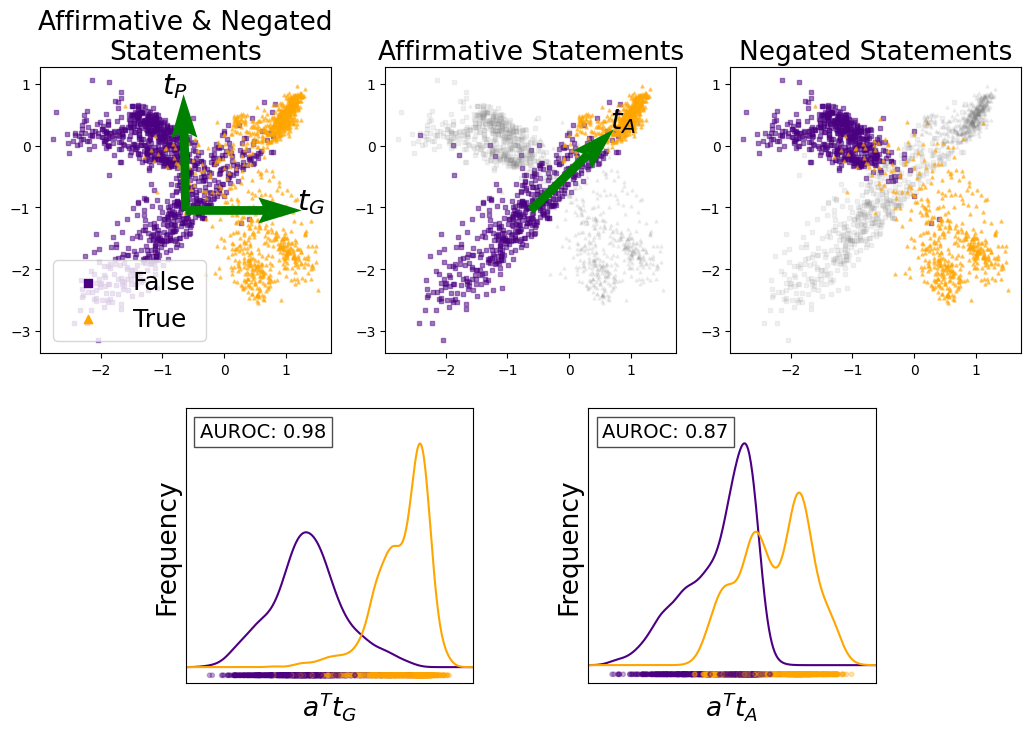

In [7]:
fig = plt.figure(figsize=(11.5, 11))
axes = [
    fig.add_axes([0.4, 0.4, 0.26, 0.26]),  # ax1: top center
    fig.add_axes([0.7, 0.4, 0.26, 0.26]),  # ax2: top right
    fig.add_axes([0.1, 0.4, 0.26, 0.26]),  # ax3: top left
    fig.add_axes([0.58, 0.1, 0.25, 0.25]), # ax4: bottom right
    fig.add_axes([0.23, 0.1, 0.25, 0.25])  # ax5: bottom left
]

# Collect activations and labels of affirmative and negated statements separately
acts_affirm, labels_affirm, acts_neg, labels_neg = collect_affirm_neg_data(train_sets, train_set_sizes,
                                                                            model_family, model_size, model_type, layer)

# Compute t_affirm
t_affirm = compute_t_affirm(acts_affirm, labels_affirm)

# orthonormalise t_g and t_p
t_g_orthonormal, t_p_orthonormal = compute_orthonormal_vectors(t_g, t_p)

# Project activations
proj_g_affirm, proj_p_affirm = project_activations(acts_affirm, t_g_orthonormal, t_p_orthonormal)
proj_g_neg, proj_p_neg = project_activations(acts_neg, t_g_orthonormal, t_p_orthonormal)

# Plot scatter plots
plot_scatter(axes[0], proj_g_affirm, proj_p_affirm, labels_affirm,
              proj_g_neg, proj_p_neg, labels_neg, 'Affirmative Statements', plot_t_a=True,
                t_affirm=t_affirm, t_g_orthonormal=t_g_orthonormal, t_p_orthonormal=t_p_orthonormal)
plot_scatter(axes[1], proj_g_neg, proj_p_neg, labels_neg, proj_g_affirm,
              proj_p_affirm, labels_affirm, 'Negated Statements')
plot_scatter(axes[2], proj_g_affirm, proj_p_affirm, labels_affirm,
              proj_g_neg, proj_p_neg, labels_neg, 'Affirmative & Negated\nStatements', plot_t_g_t_p=True,
                t_g=t_g, t_p=t_p, t_g_orthonormal=t_g_orthonormal, t_p_orthonormal=t_p_orthonormal)

# Add legend
add_legend(axes[2])

# Plot density plots
acts = torch.cat((acts_affirm, acts_neg), dim=0)
labels = torch.cat((labels_affirm, labels_neg))
plot_density(axes[3], acts, labels, t_affirm, '$a^T t_A$')
plot_density(axes[4], acts, labels, t_g, '$a^T t_G$')

plt.show()

#### Activation vectors projected onto $t_G$ and $t_P$ (reduced version of figure 1)

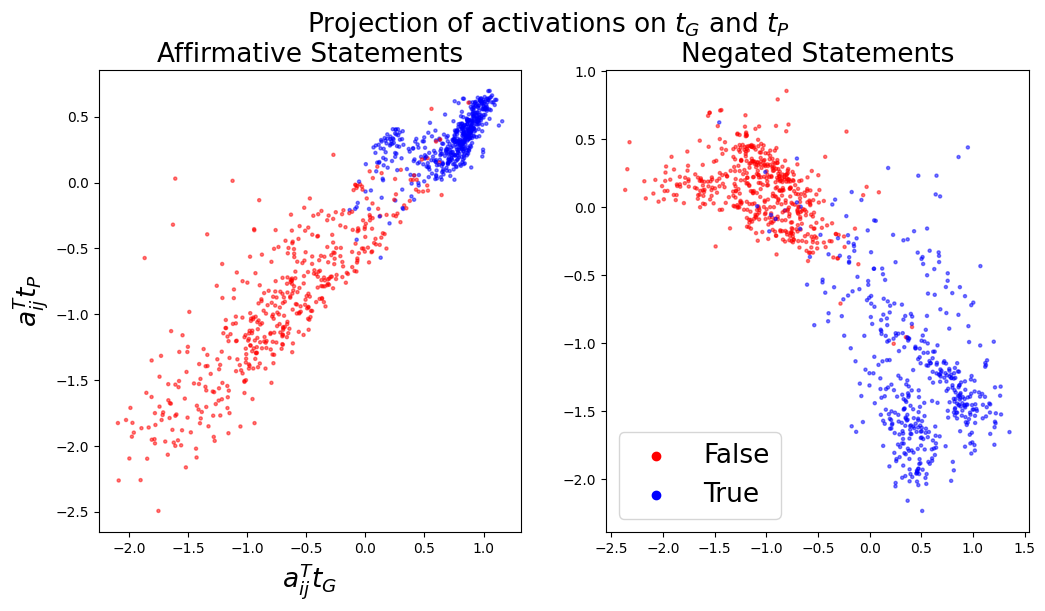

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
acts_affirm, labels_affirm, acts_neg, labels_neg = collect_affirm_neg_data(train_sets, train_set_sizes, 
                                                                            model_family, model_size, 
                                                                            model_type, layer)

for i, (acts, labels) in enumerate([(acts_affirm, labels_affirm), (acts_neg, labels_neg)]):
    prod_g, prod_p = project_activations(acts, t_g, t_p)
    ax = axes[i]
    if i==0:
        ax.set_xlabel('$a_{ij}^T t_G$', fontsize=19)
        ax.set_ylabel('$a_{ij}^T t_P$', fontsize=19)
        ax.set_title('Affirmative Statements', fontsize=19)
    else:
        ax.set_title('Negated Statements', fontsize=19)

    colors = ['red' if label == 0 else 'blue' for label in labels]
    ax.scatter(prod_g, prod_p, c=colors, alpha=0.5, s=5)

# Add the legend to the last subplot
handles = [plt.scatter([], [], c='red', label='False'),
            plt.scatter([], [], c='blue', label='True')]
axes[1].legend(handles=handles, fontsize=19)

fig.suptitle('Projection of activations on $t_G$ and $t_P$', fontsize=19)
plt.show()

#### Projection of other datasets onto $t_G$ and $t_P$ - larger_than and smaller_than are shown as examples

Text(0.5, 0.98, 'Projection of activations on $t_G$ and $t_P$')

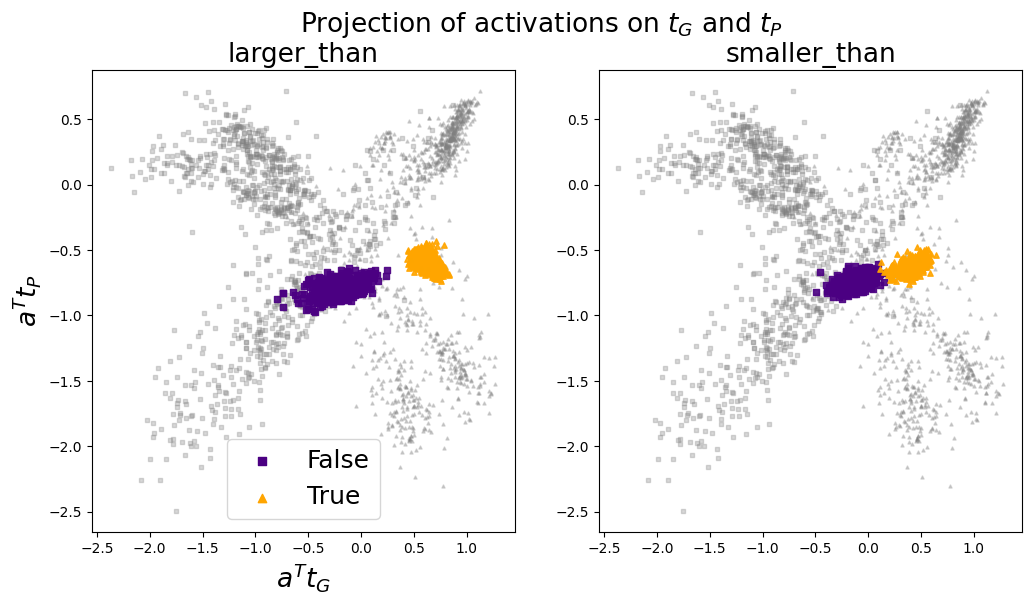

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  

acts_affirm, labels_affirm, acts_neg, labels_neg = collect_affirm_neg_data(train_sets, train_set_sizes, model_family,
                                                                            model_size, model_type, layer)
# Project activations on t_g and t_p
proj_g_affirm, proj_p_affirm = project_activations(acts_affirm, t_g, t_p)
proj_g_neg, proj_p_neg = project_activations(acts_neg, t_g, t_p)

# Define colors and markers for each label
label_to_color = {0: 'indigo', 1: 'orange'}
label_to_marker = {0: 's', 1: '^'}  # s for square, ^ for triangle

for i, dataset_name in enumerate(['larger_than', 'smaller_than']):
        ax = axes[i]
        ax.set_title(dataset_name, fontsize=19)
        for label in [0,1]:
                idx = labels_affirm.numpy() == label
                ax.scatter(proj_g_affirm[idx], proj_p_affirm[idx], c='grey', 
                        marker=label_to_marker[label], alpha=0.3, s=5) 
                idx = labels_neg.numpy() == label
                ax.scatter(proj_g_neg[idx], proj_p_neg[idx], c='grey', 
                        marker=label_to_marker[label], alpha=0.3, s=5) 
        
        dm = DataManager()
        dm.add_dataset(dataset_name, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
        acts, labels = dm.data[dataset_name]
        prod_g, prod_p = project_activations(acts, t_g, t_p)
        for label in [0,1]:
                idx = labels.numpy() == label
                ax.scatter(prod_g[idx], prod_p[idx], c=label_to_color[label], 
                        marker=label_to_marker[label], alpha=0.9, s=15)
                if i==0:
                        ax.set_xlabel('$a^T t_G$', fontsize=19)
                        ax.set_ylabel('$a^T t_P$', fontsize=19)

add_legend(axes[0])
fig.suptitle('Projection of activations on $t_G$ and $t_P$', fontsize=19)

### Dimensionality of Truth
#### Are there more than two truth dimensions?

#### Fraction of truth related variance in activations explained by Principal Components

Principal angles between subspaces (in radians): tensor([0.0000, 0.2065])
Principal angles between subspaces (in degrees): tensor([ 0.0000, 11.8323])
Cosine similarity between t_G and first PC: tensor(0.9814)
Cosine similarity between t_P and second PC: tensor(0.9810)


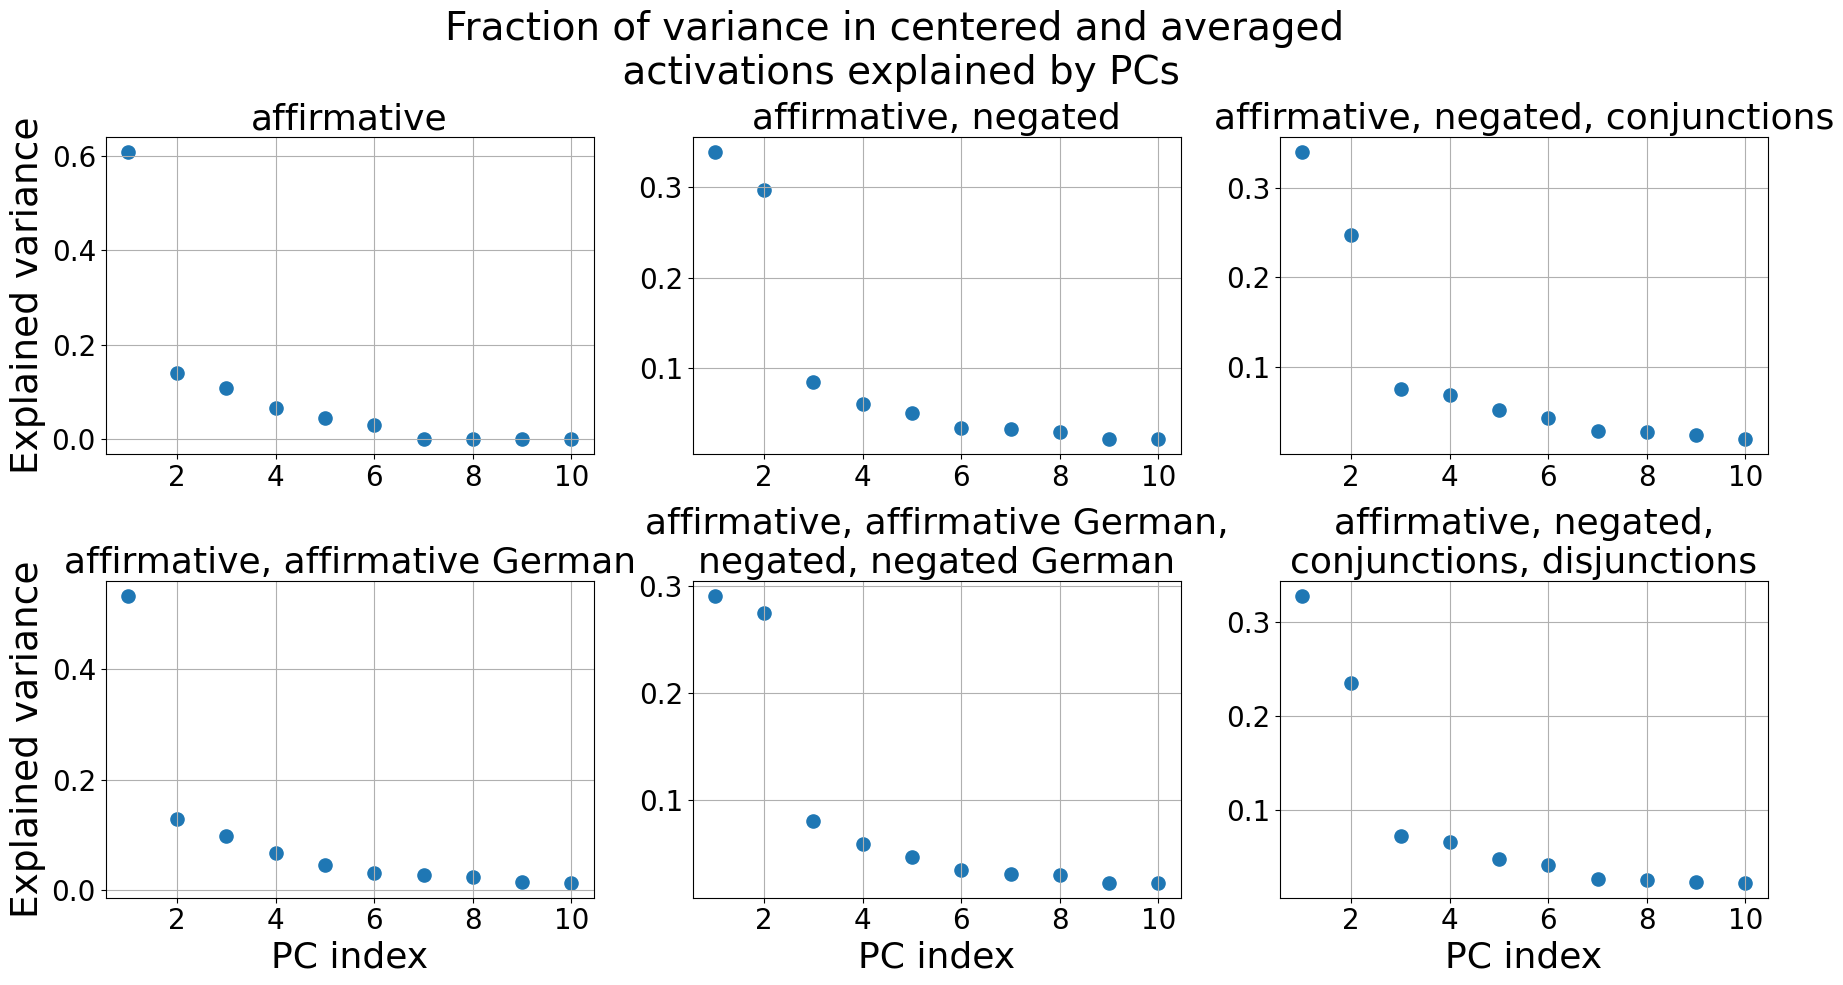

In [10]:
# Define the four different statement types and corresponding datasets
statement_types = ["affirmative", "affirmative, negated", "affirmative, negated, conjunctions", "affirmative, affirmative German",
                    "affirmative, affirmative German,\nnegated, negated German", 
                   "affirmative, negated,\nconjunctions, disjunctions"]
datasets_pca_options = {
    "affirmative": ['cities', 'sp_en_trans', 'inventors', 'animal_class', 'element_symb', 'facts'],
    
    "affirmative, negated": ['cities', 'sp_en_trans', 'inventors', 'animal_class', 'element_symb', 'facts',
                             'neg_cities', 'neg_sp_en_trans', 'neg_inventors', 'neg_animal_class', 'neg_element_symb', 'neg_facts'],

    "affirmative, negated, conjunctions": ['cities', 'sp_en_trans', 'inventors', 'animal_class', 'element_symb', 'facts',
                             'neg_cities', 'neg_sp_en_trans', 'neg_inventors', 'neg_animal_class', 'neg_element_symb', 'neg_facts',
                             'cities_conj', 'sp_en_trans_conj', 'inventors_conj', 'animal_class_conj', 'element_symb_conj', 'facts_conj'],
    
    "affirmative, affirmative German": ['cities', 'sp_en_trans', 'inventors', 'animal_class', 'element_symb', 'facts',
                             'cities_de', 'sp_en_trans_de', 'inventors_de', 'animal_class_de', 'element_symb_de', 'facts_de',],

    "affirmative, affirmative German,\nnegated, negated German": ['cities', 'sp_en_trans', 'inventors', 'animal_class', 'element_symb', 'facts',
                            'cities_de', 'sp_en_trans_de', 'inventors_de', 'animal_class_de', 'element_symb_de', 'facts_de',
                             'neg_cities', 'neg_sp_en_trans', 'neg_inventors', 'neg_animal_class', 'neg_element_symb', 'neg_facts',
                             'neg_cities_de', 'neg_sp_en_trans_de', 'neg_inventors_de', 'neg_animal_class_de', 'neg_element_symb_de', 'neg_facts_de'],

    "affirmative, negated,\nconjunctions, disjunctions": ['cities', 'sp_en_trans', 'inventors', 'animal_class', 'element_symb', 'facts',
                             'neg_cities', 'neg_sp_en_trans', 'neg_inventors', 'neg_animal_class', 'neg_element_symb', 'neg_facts',
                             'cities_conj', 'sp_en_trans_conj', 'inventors_conj', 'animal_class_conj', 'element_symb_conj', 'facts_conj',
                             'cities_disj', 'sp_en_trans_disj', 'inventors_disj', 'animal_class_disj', 'element_symb_disj', 'facts_disj']
}

def compute_subspace_angle(A, B):
    # Normalize columns of A and B
    A = A / torch.linalg.norm(A, dim=0)
    B = B / torch.linalg.norm(B, dim=0)
    
    # Compute SVD of A^T * B
    U, S, Vt = torch.linalg.svd(A.T @ B)
    
    # Compute principal angles
    angles = torch.arccos(torch.clamp(S, -1, 1))
    
    return angles

# Create the 2x2 plot
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, statement_type in enumerate(statement_types):
    datasets_pca = datasets_pca_options[statement_type]
    directions = []

    for train_set in datasets_pca:
        dm = DataManager()
        dm.add_dataset(train_set, model_family, model_size, model_type, layer, split=1.0, center=True, device='cpu')
        train_acts, train_labels = dm.get('train')
        true_acts = train_acts[train_labels.to(bool)]
        false_acts = train_acts[~train_labels.to(bool)]
        directions.append(torch.mean(true_acts, dim=0))
        directions.append(torch.mean(false_acts, dim=0))

    mean_acts = np.array([direction.numpy() for direction in directions])
    pca = PCA(n_components=10)
    pca.fit(mean_acts)
    axs[i].scatter(np.arange(1, 11, 1), pca.explained_variance_ratio_, s=90)
    axs[i].set_title(f'{statement_type}', fontsize=26)
    if i == 0 or i==3:
        axs[i].set_ylabel('Explained variance', fontsize=27)
    if i==3 or i == 4 or i==5:
        axs[i].set_xlabel('PC index', fontsize=26)
    axs[i].tick_params(axis='both', which='major', labelsize=20)
    axs[i].grid(True)
    if statement_type == "affirmative, negated":
        # Compute subspace angle
        A = torch.stack([t_g, t_p], dim=1)
        B = torch.stack([torch.tensor(pca.components_[0, :]), torch.tensor(pca.components_[1, :])], dim=1)
        angles = compute_subspace_angle(A, B)
        print(f"Principal angles between subspaces (in radians): {angles}")
        print(f"Principal angles between subspaces (in degrees): {torch.rad2deg(angles)}")
        print("Cosine similarity between t_G and first PC: " + str(torch.tensor(pca.components_[0, :])/torch.linalg.norm(torch.tensor(pca.components_[0, :])) @ t_g/np.linalg.norm(t_g)))
        print("Cosine similarity between t_P and second PC: " + str(torch.tensor(pca.components_[1, :])/torch.linalg.norm(torch.tensor(pca.components_[1, :])) @ t_p/np.linalg.norm(t_p)))

fig.suptitle('Fraction of variance in centered and averaged\n activations explained by PCs', fontsize=28)
plt.tight_layout()
plt.show()

#### Generalisation accuracies of truth directions trained on different data

In [11]:
train_sets_subset = [['cities'], ['cities', 'neg_cities'], ['cities', 'neg_cities', 'cities_conj'],
                     ['cities', 'neg_cities', 'cities_conj', 'cities_disj']]

val_sets_subset = ['cities', 'neg_cities', 'facts', 'neg_facts',
                   'facts_conj', 'facts_disj']

num_runs = 10
project_options = [None, 't_G_t_P']

# Helper function to create unique keys for training sets
def get_train_set_key(train_set):
    return '_'.join(train_set)

# Initialize dictionaries to store accuracies for each projection option
all_aurocs_options = {proj: {get_train_set_key(train_set): {val_set: [] for val_set in val_sets_subset} for train_set in train_sets_subset} for proj in project_options}

for project_out in project_options:
    all_aurocs = all_aurocs_options[project_out]

    for run in range(num_runs):
        # Compute t_g and t_p using all data
        acts_centered, _, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, 
                                                            model_size, model_type, layer)
        t_g, t_p = learn_truth_directions(acts_centered, labels, polarities)
        # orthonormalize t_g and t_p
        t_G_orthonormal, t_P_orthonormal = compute_orthonormal_vectors(t_g, t_p)

        for train_set in train_sets_subset:
            train_set_key = get_train_set_key(train_set)
            
            # set up data
            dm = DataManager()
            for subset in train_set:
                dm.add_dataset(subset, model_family, model_size, model_type, layer, split=0.8, center=True, device='cpu')
            train_acts, train_labels = dm.get('train')
            if project_out == None:
                pass
            elif project_out == 't_G_t_P':
                train_acts = train_acts - (train_acts @ t_G_orthonormal)[:, None] * t_G_orthonormal - (train_acts @ t_P_orthonormal)[:, None] * t_P_orthonormal
            polarities = torch.zeros((train_labels.shape)[0])
            # learn t_G
            t_g_trained, _ = learn_truth_directions(train_acts, train_labels, polarities)
            
            # compute auroc of a^T t_G on validation sets
            for val_set in val_sets_subset:
                if val_set in train_set:
                    acts, labels = dm.get('val')
                else:
                    dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                    acts, labels = dm.data[val_set]
                
                proj_g = acts @ t_g_trained
                auroc = roc_auc_score(labels.numpy(), proj_g.numpy())
                all_aurocs[train_set_key][val_set].append(auroc)

    # Calculate mean and standard deviation for each training-validation set combination
    mean_aurocs = {train_set: {val_set: np.mean(accs) for val_set, accs in val_sets.items()} for train_set, val_sets in all_aurocs.items()}
    std_aurocs = {train_set: {val_set: np.std(accs) for val_set, accs in val_sets.items()} for train_set, val_sets in all_aurocs.items()}

    all_aurocs_options[project_out] = {'mean': mean_aurocs, 'std': std_aurocs}
    print(mean_aurocs, std_aurocs)

{'cities': {'cities': 0.9999866565714504, 'neg_cities': 0.80453633932912, 'facts': 0.9333930704898445, 'neg_facts': 0.5344467322504386, 'facts_conj': 0.7707049306625577, 'facts_disj': 0.6463058626627399}, 'cities_neg_cities': {'cities': 0.9999588311645609, 'neg_cities': 0.9999588311645609, 'facts': 0.9541968529957549, 'neg_facts': 0.917833447723633, 'facts_conj': 0.8327170005136108, 'facts_disj': 0.7326107597483061}, 'cities_neg_cities_cities_conj': {'cities': 0.9997506833504056, 'neg_cities': 0.9997506833504056, 'facts': 0.9625295508274231, 'neg_facts': 0.8987823788098325, 'facts_conj': 0.8531009244992296, 'facts_disj': 0.7644385973382255}, 'cities_neg_cities_cities_conj_cities_disj': {'cities': 0.9948495003450308, 'neg_cities': 0.9948495003450308, 'facts': 0.9625066727674826, 'neg_facts': 0.8987887338264826, 'facts_conj': 0.8543464304057524, 'facts_disj': 0.7744733581164808}} {'cities': {'cities': 2.846999558726635e-05, 'neg_cities': 0.0023929918248508345, 'facts': 0.0002213882037652

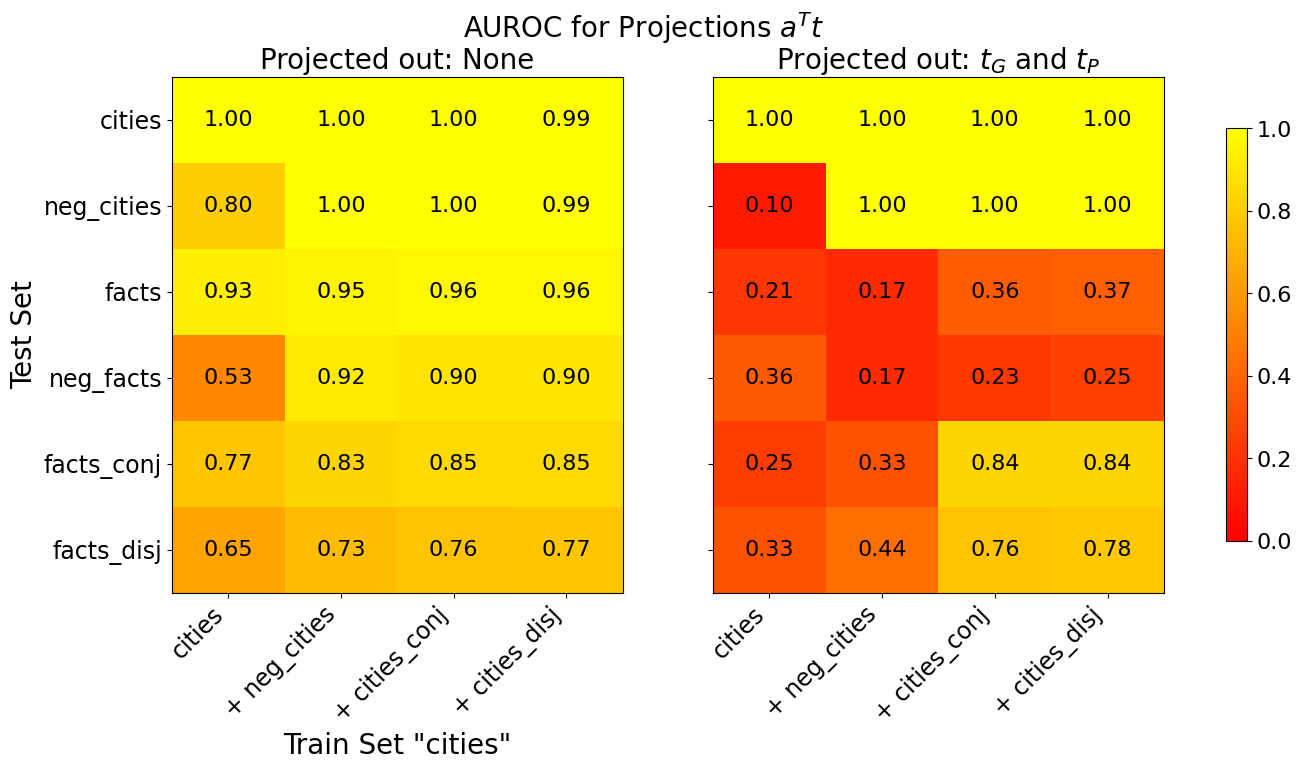

In [12]:
# Plotting the results
fig, axes = plt.subplots(figsize=(16, 6.7), nrows=1, ncols=2, sharey=True)
# Titles for the x and y axes
titles_val = ['cities', 'neg_cities', 'facts', 'neg_facts',
                'facts_conj', 'facts_disj']
titles_train = ['cities', '+ neg_cities', '+ cities_conj', '+ cities_disj']

# Create a custom colormap from red to yellow
colors = [(1, 0, 0), (1, 1, 0)]  # Red to Yellow
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'red_yellow'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

for idx, project_out in enumerate(project_options):
    mean_aurocs = all_aurocs_options[project_out]['mean']
    std_aurocs = all_aurocs_options[project_out]['std']
    
    # Prepare the grid for mean accuracies
    grid = np.zeros((len(train_sets_subset), len(val_sets_subset)))

    # Populate the grid with mean accuracies
    for i, train_set in enumerate(train_sets_subset):
        train_set_key = get_train_set_key(train_set)
        for j, val_set in enumerate(val_sets_subset):
            grid[i, j] = mean_aurocs[train_set_key][val_set]

    # Plot the grid
    im = axes[idx].imshow(grid.T, vmin=0, vmax=1, cmap=cmap, aspect='auto')

    # Annotate each cell with the mean accuracy and standard deviation
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            mean_auroc = grid[i][j]
            std_auroc = std_aurocs[get_train_set_key(train_sets_subset[i])][val_sets_subset[j]]
            axes[idx].text(i, j, f'{mean_auroc:.2f}', ha='center', va='center', fontsize=16) #±{std_auroc:.2f}


    # Titles for the x and y axes
    axes[idx].set_yticks(range(len(val_sets_subset)))
    axes[idx].set_xticks(range(len(train_sets_subset)))
    axes[idx].set_yticklabels([val_title for val_title in titles_val], fontsize=17)
    axes[idx].set_xticklabels([train_title for train_title in titles_train], rotation=45, ha='right', fontsize=17)

    # Set title and labels for the subplot
    if idx == 0:
        axes[idx].set_title(f'Projected out: None', fontsize=20)
    if idx == 1:
        axes[idx].set_title(f'Projected out: $t_G$ and $t_P$', fontsize=20)
    if idx == 0:
        axes[idx].set_ylabel('Test Set', fontsize=20)
        axes[idx].set_xlabel('Train Set "cities"', fontsize=20)

# Add colorbar to the last subplot
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
cbar.ax.tick_params(labelsize=16)
fig.suptitle('AUROC for Projections $a^T t$', fontsize=20, x=0.42)

# Show the plot
plt.show()

### Cross-dataset generalization matrix

In [13]:
train_sets_subset = [['cities'], ['neg_cities'], ['cities', 'neg_cities'], ['cities_conj'], ['cities_disj']]

val_sets_subset = ['cities', 'neg_cities', 'facts', 'neg_facts',
                   'facts_conj', 'facts_disj']

num_runs = 10

# Helper function to create unique keys for training sets
def get_train_set_key(train_set):
    return '_'.join(train_set)

# Initialize dictionaries to store accuracies for each projection option
all_aurocs = {get_train_set_key(train_set): {val_set: [] for val_set in val_sets_subset} for train_set in train_sets_subset}
for run in range(num_runs):
    for train_set in train_sets_subset:
        train_set_key = get_train_set_key(train_set)
        
        # set up data
        dm = DataManager()
        for subset in train_set:
            dm.add_dataset(subset, model_family, model_size, model_type, layer, split=0.8, center=True, device='cpu')
        train_acts, train_labels = dm.get('train')
        polarities = torch.zeros((train_labels.shape)[0])
        # learn t_G
        t_g_trained, _ = learn_truth_directions(train_acts, train_labels, polarities)
        
        # compute auroc of a^T t_G on validation sets
        for val_set in val_sets_subset:
            if val_set in train_set:
                acts, labels = dm.get('val')
            else:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
            
            proj_g = acts @ t_g_trained
            auroc = roc_auc_score(labels.numpy(), proj_g.numpy())
            all_aurocs[train_set_key][val_set].append(auroc)

# Calculate mean and standard deviation for each training-validation set combination
mean_aurocs = {train_set: {val_set: np.mean(accs) for val_set, accs in val_sets.items()} for train_set, val_sets in all_aurocs.items()}
std_aurocs = {train_set: {val_set: np.std(accs) for val_set, accs in val_sets.items()} for train_set, val_sets in all_aurocs.items()}

all_aurocs = {'mean': mean_aurocs, 'std': std_aurocs}
print(mean_aurocs, std_aurocs)

{'cities': {'cities': 0.9999866251185408, 'neg_cities': 0.8047289206154022, 'facts': 0.9334057805231449, 'neg_facts': 0.5339052848318463, 'facts_conj': 0.7706086286594761, 'facts_disj': 0.6465054152786495}, 'neg_cities': {'cities': 0.7847343361262833, 'neg_cities': 1.0, 'facts': 0.9356986705305168, 'neg_facts': 0.9489819263326471, 'facts_conj': 0.7862175783256291, 'facts_disj': 0.7364666312621703}, 'cities_neg_cities': {'cities': 0.9999364828413171, 'neg_cities': 0.9999364828413171, 'facts': 0.9543925875085794, 'neg_facts': 0.9181029004295992, 'facts_conj': 0.8330701078582434, 'facts_disj': 0.7329519303497}, 'cities_conj': {'cities': 0.9999946381080387, 'neg_cities': 0.9999982127026795, 'facts': 0.9668967182694018, 'neg_facts': 0.7921083403238516, 'facts_conj': 0.8628771828454032, 'facts_disj': 0.7792239978113583}, 'cities_disj': {'cities': 0.9999878463782206, 'neg_cities': 0.9999681861076952, 'facts': 0.9195391341925315, 'neg_facts': 0.8676593202674191, 'facts_conj': 0.845659989727786

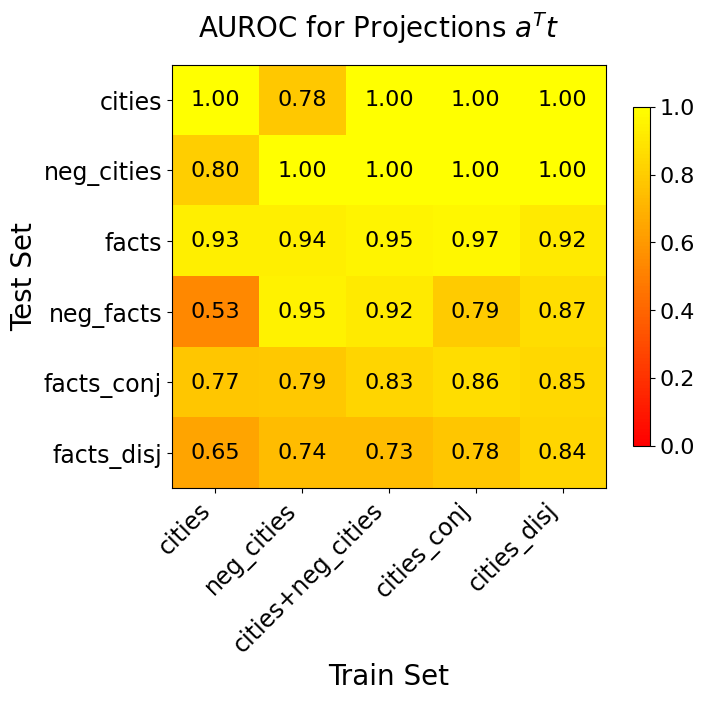

In [14]:
# Plotting the results
fig, ax = plt.subplots(figsize=(7, 5.5), nrows=1, ncols=1, sharey=True)
# Titles for the x and y axes
titles_val = ['cities', 'neg_cities', 'facts', 'neg_facts',
                'facts_conj', 'facts_disj']
titles_train = ['cities', 'neg_cities', 'cities+neg_cities', 'cities_conj', 'cities_disj']

# Create a custom colormap from red to yellow
colors = [(1, 0, 0), (1, 1, 0)]  # Red to Yellow
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'red_yellow'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

mean_aurocs = all_aurocs['mean']
std_aurocs = all_aurocs['std']

# Prepare the grid for mean accuracies
grid = np.zeros((len(train_sets_subset), len(val_sets_subset)))

# Populate the grid with mean accuracies
for i, train_set in enumerate(train_sets_subset):
    train_set_key = get_train_set_key(train_set)
    for j, val_set in enumerate(val_sets_subset):
        grid[i, j] = mean_aurocs[train_set_key][val_set]

# Plot the grid
im = ax.imshow(grid.T, vmin=0, vmax=1, cmap=cmap, aspect='auto')

# Annotate each cell with the mean accuracy and standard deviation
for i in range(len(grid)):
    for j in range(len(grid[0])):
        mean_auroc = grid[i][j]
        std_auroc = std_aurocs[get_train_set_key(train_sets_subset[i])][val_sets_subset[j]]
        ax.text(i, j, f'{mean_auroc:.2f}', ha='center', va='center', fontsize=16) #±{std_auroc:.2f}


    # Titles for the x and y axes
    ax.set_yticks(range(len(val_sets_subset)))
    ax.set_xticks(range(len(train_sets_subset)))
    ax.set_yticklabels([val_title for val_title in titles_val], fontsize=17)
    ax.set_xticklabels([train_title for train_title in titles_train], rotation=45, ha='right', fontsize=17)

    ax.set_ylabel('Test Set', fontsize=20)
    ax.set_xlabel('Train Set', fontsize=20)

# Add colorbar to the last subplot
cbar = fig.colorbar(im, shrink=0.8)
cbar.ax.tick_params(labelsize=16)
fig.suptitle('AUROC for Projections $a^T t$', fontsize=20, x=0.42)

# Show the plot
plt.show()

In [15]:
data = np.zeros((100,2))
# zeroth feature is perfectly predictive of label
data[0:50,0] = 1.0
# first feature is correlated with the correct label but not perfectly, 20 correct, 5 incorrect
data[0:20, 1] = 1.0
data[50:55, 1] = 1.0
labels = np.concatenate((np.ones(50), np.zeros(50)))
# which method can disentangle feature 0 from feature 1?
# mass mean
d_mm = np.mean(data[labels == 1.0], axis=0) - np.mean(data[labels==0.0], axis=0)
print(d_mm)
# LR
LR = LogisticRegression(penalty=None, fit_intercept = True)
LR.fit(data, labels)
d_LR = LR.coef_
print(LR.intercept_)
print(d_LR) 

[1.  0.3]
[-8.64487912]
[[17.45643835  0.51397599]]
